# Preamble

In [6]:
%matplotlib inline

import os
import sympy as sm
import scipy as sp
import numpy as np
import matplotlib as mpl
import matplotlib.ticker as ticker

from matplotlib import pyplot as plt
from scipy.special import hyp2f1
from sympy import init_printing, init_session

init_session()
init_printing()

def Pochhammer(a, k):
    if k == 0:
        return 1.0
    else:
        return (a + k - 1) * Pochhammer(a, k - 1)


def b(s, j, alpha):
    if j >= 0:  # Eq. 7.87
        return (
            2
            * Pochhammer(s, j)
            / Pochhammer(1, j)
            * (alpha**j)
            * hyp2f1(s, s + j, j + 1, alpha * alpha)
        )
    else:  # Eq. 6.69
        return b(s, -j, alpha)


def Db(s, j, alpha):  # Eq. 6.70
    aux = (
        b(s + 1, j - 1, alpha) - 2 * alpha * b(s + 1, j, alpha) + b(s + 1, j + 1, alpha)
    )
    return s * aux


def D2b(s, j, alpha):  # Eq. 6.71
    aux = (
        Db(s + 1, j - 1, alpha)
        - 2 * alpha * Db(s + 1, j, alpha)
        - 2 * b(s + 1, j, alpha)
        + Db(s + 1, j + 1, alpha)
    )
    return s * aux


def f27lc(alpha, j):
    """
    f27 in MD p543
    (1/2)[−2 j − αD] b^(j)_{1/2}(α) x [e1cos(theta1)]
    """
    return 0.5 * (-2 * (j + 1) * b(0.5, j + 1, alpha) - alpha * Db(0.5, j + 1, alpha))


def f31lc(alpha, j):
    """
    f31 in MD p543
    (1/2)[−1 + 2 j + αD] b^(j-1)_{1/2}(α) x [e2cos(theta2)]
    """
    return 0.5 * ((-1 + 2 * (j + 1)) * b(0.5, j, alpha) + alpha * Db(0.5, j, alpha))

alpha0 = (2 / (2 + 1)) ** (2.0 / 3)

############################################################
# If test particle is outside, have to multiply by alpha_0 #
############################################################

f1val_outside = alpha0*f27lc(alpha0, 2)
f2val_outside = alpha0*f31lc(alpha0, 2)

IPython console for SymPy 1.11.1 (Python 3.11.3-64-bit) (ground types: gmpy)

These commands were executed:
>>> from sympy import *
>>> x, y, z, t = symbols('x y z t')
>>> k, m, n = symbols('k m n', integer=True)
>>> f, g, h = symbols('f g h', cls=Function)
>>> init_printing()

Documentation can be found at https://docs.sympy.org/1.11.1/



In [7]:
import subprocess
def save_to_clipboard(dpi=300):
    plt.savefig("/tmp/clipboard.png", format="png", bbox_inches="tight", dpi=dpi)
    subprocess.run(
        [
            "osascript",
            "-e",
            f'set the clipboard to (read (POSIX file "/tmp/clipboard.png") as «class PNGf»)',
        ]
    )

# Equations

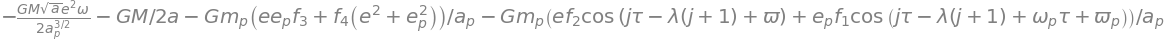

In [8]:
f1, f2, f3, f4, tau, l, pom, pom_p, g, om, om_p, T = sm.symbols(
    "f_1 f_2 f_3 f_4 tau lambda varpi varpi_p gamma omega omega_p T"
)
a, a_p, e, e_p, n, n_p, m_p, mu_p, L, G, Gconst, M, j = sm.symbols(
    "a a_p e e_p n n_p m_p mu_p Lambda Gamma G M j", positive=True
)
X, Y, Te, Tm = sm.symbols("X Y T_e T_m")

H_scale_factor = Gconst * M / a_p
t_scale_factor = sqrt(Gconst * M / a_p**3)  # = n_p
L_scale_factor = H_scale_factor / t_scale_factor

calH = (
    -(Gconst * M) / (2 * a)
    - Gconst
    * m_p
    / a_p
    * (
        e * f2 * sm.cos((j + 1) * l - j * tau - pom)
        + e_p * f1 * sm.cos((j + 1) * l - j * tau - pom_p - om_p * tau)
    )
    - (Gconst * m_p / a_p * (f3 * e * e_p + f4 * (e**2 + e_p**2)))
    - Rational(1, 2) * sqrt(Gconst * M * a) * e**2 * om * t_scale_factor
)


display(calH)
calH = (
    (calH / H_scale_factor)
    .subs(m_p, mu_p * M)
    .simplify()
    .expand()
    .subs({f3: 0, f4: 0})
    #.subs(a, a * a_p)
) + T
display(calH)

In [9]:
def to_canonical(expr):
    return expr.subs({a: L**2, e: sqrt(2 * G / L), pom: -g})


def to_orbelts(expr):
    # This uses the approximation G=1/2*L*e^2
    return expr.subs({g: -pom, G: Rational(1, 2) * L * e**2, L: sqrt(a)})

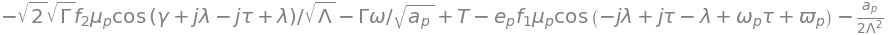

In [10]:
Hcanon = to_canonical(calH)
Hcanon

In [11]:
x = Matrix([tau,l,g,T,L,G])
x

⎡τ⎤
⎢ ⎥
⎢λ⎥
⎢ ⎥
⎢γ⎥
⎢ ⎥
⎢T⎥
⎢ ⎥
⎢Λ⎥
⎢ ⎥
⎣Γ⎦

In [12]:
pHpx = Matrix([Hcanon]).jacobian(x).T
pHpx

⎡    √2⋅√Γ⋅f₂⋅j⋅μₚ⋅sin(γ + j⋅λ - j⋅τ + λ)                                     
⎢  - ──────────────────────────────────── + eₚ⋅f₁⋅μₚ⋅(j + ωₚ)⋅sin(-j⋅λ + j⋅τ -
⎢                     √Λ                                                      
⎢                                                                             
⎢√2⋅√Γ⋅f₂⋅μₚ⋅(j + 1)⋅sin(γ + j⋅λ - j⋅τ + λ)                                   
⎢────────────────────────────────────────── + eₚ⋅f₁⋅μₚ⋅(-j - 1)⋅sin(-j⋅λ + j⋅τ
⎢                    √Λ                                                       
⎢                                                                             
⎢                                √2⋅√Γ⋅f₂⋅μₚ⋅sin(γ + j⋅λ - j⋅τ + λ)           
⎢                                ──────────────────────────────────           
⎢                                                √Λ                           
⎢                                                                             
⎢                                                1  

In [13]:
J = Matrix(BlockMatrix([[zeros(3,3),eye(3)],[-eye(3),zeros(3,3)]]))
J

⎡0   0   0   1  0  0⎤
⎢                   ⎥
⎢0   0   0   0  1  0⎥
⎢                   ⎥
⎢0   0   0   0  0  1⎥
⎢                   ⎥
⎢-1  0   0   0  0  0⎥
⎢                   ⎥
⎢0   -1  0   0  0  0⎥
⎢                   ⎥
⎣0   0   -1  0  0  0⎦

In [14]:
dxdt = J*pHpx
dxdt

⎡                                                 1                           
⎢                                                                             
⎢                              √2⋅√Γ⋅f₂⋅μₚ⋅cos(γ + j⋅λ - j⋅τ + λ)   aₚ        
⎢                              ────────────────────────────────── + ──        
⎢                                               3/2                  3        
⎢                                            2⋅Λ                    Λ         
⎢                                                                             
⎢                                 ω      √2⋅f₂⋅μₚ⋅cos(γ + j⋅λ - j⋅τ + λ)      
⎢                             - ────── - ───────────────────────────────      
⎢                                 ____               2⋅√Γ⋅√Λ                  
⎢                               ╲╱ aₚ                                         
⎢                                                                             
⎢    √2⋅√Γ⋅f₂⋅j⋅μₚ⋅sin(γ + j⋅λ - j⋅τ + λ)           

In [15]:
p2Hpx2 = pHpx.jacobian(x)
p2Hpx2

⎡                  2                                                          
⎢        √2⋅√Γ⋅f₂⋅j ⋅μₚ⋅cos(γ + j⋅λ - j⋅τ + λ)                    2           
⎢        ───────────────────────────────────── + eₚ⋅f₁⋅μₚ⋅(j + ωₚ) ⋅cos(-j⋅λ +
⎢                          √Λ                                                 
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢  √2⋅√Γ⋅f₂⋅j⋅μₚ⋅(j + 1)⋅cos(γ + j⋅λ - j⋅τ + λ)                               
⎢- ──────────────────────────────────────────── + eₚ⋅f₁⋅μₚ⋅(-j - 1)⋅(j + ωₚ)⋅c
⎢                       √Λ                                                    
⎢                                                                             
⎢                                                                             
⎢                                    -√2⋅√Γ⋅f₂⋅j⋅μₚ⋅

In [16]:
dxdt

⎡                                                 1                           
⎢                                                                             
⎢                              √2⋅√Γ⋅f₂⋅μₚ⋅cos(γ + j⋅λ - j⋅τ + λ)   aₚ        
⎢                              ────────────────────────────────── + ──        
⎢                                               3/2                  3        
⎢                                            2⋅Λ                    Λ         
⎢                                                                             
⎢                                 ω      √2⋅f₂⋅μₚ⋅cos(γ + j⋅λ - j⋅τ + λ)      
⎢                             - ────── - ───────────────────────────────      
⎢                                 ____               2⋅√Γ⋅√Λ                  
⎢                               ╲╱ aₚ                                         
⎢                                                                             
⎢    √2⋅√Γ⋅f₂⋅j⋅μₚ⋅sin(γ + j⋅λ - j⋅τ + λ)           

In [17]:
y1, y2, y3, y4, y5, y6 = sm.symbols("y_1 y_2 y_3 y_4 y_5 y_6")
y = Matrix([y1, y2, y3, y4, y5, y6])
y

⎡y₁⎤
⎢  ⎥
⎢y₂⎥
⎢  ⎥
⎢y₃⎥
⎢  ⎥
⎢y₄⎥
⎢  ⎥
⎢y₅⎥
⎢  ⎥
⎣y₆⎦

In [18]:
dydt = J*p2Hpx2*y
dydt

⎡                                                                             
⎢                                                                             
⎢                                                                           √2
⎢                                                                           ──
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                   

In [19]:
RHS = Matrix.vstack(dxdt, dydt)
RHS

⎡                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                   

In [20]:
xy = Matrix.vstack(x,y)
xy

⎡τ ⎤
⎢  ⎥
⎢λ ⎥
⎢  ⎥
⎢γ ⎥
⎢  ⎥
⎢T ⎥
⎢  ⎥
⎢Λ ⎥
⎢  ⎥
⎢Γ ⎥
⎢  ⎥
⎢y₁⎥
⎢  ⎥
⎢y₂⎥
⎢  ⎥
⎢y₃⎥
⎢  ⎥
⎢y₄⎥
⎢  ⎥
⎢y₅⎥
⎢  ⎥
⎣y₆⎦

In [21]:
len(xy)

# Single runs

In [22]:
params = {
    a_p:1,
    e_p:0.1,
    mu_p:3e-6,
    pom_p:0,
    om:0,
    om_p:0,
    f1:f1val_outside,
    f2:f2val_outside,
    j:2,
}
rhs = RHS.subs(params)
rhs.free_symbols

In [23]:
rhs.free_symbols

In [24]:
rhsfunc = lambdify([t,*xy],rhs)

In [25]:
def func(t, Y):
    return rhsfunc(t, Y[0], Y[1], Y[2], Y[3], Y[4], Y[5], Y[6], Y[7], Y[8], Y[9], Y[10], Y[11])[:,0]


In [26]:
initorb = {
    a:1.4,
    e:0.04,
    pom:0,
    l:np.pi/3
}
initcanon = {
    t:0,
    T:1,
    l:to_orbelts(l).subs(initorb),
    g:to_orbelts(g).subs(initorb),
    L:to_orbelts(L).subs(initorb),
    G:to_orbelts(G).subs(initorb),
    tau:0,
}
initcanon

In [27]:
rhsfunc

<function _lambdifygenerated(t, tau, lambda_, gamma, T, Lambda, Gamma, y_1, y_2, y_3, y_4, y_5, y_6)>

In [28]:
#inity = dxdt.subs(params).subs(initcanon).subs({}).evalf()
#inity = inity/sqrt((inity.T*inity)[0]) # normalize
inity = [0,0,0,1,0,0]
inity = {y[i]:el for i, el in enumerate(inity)}
inity

In [29]:
def func(t, Y):
    #return rhsfunc(t, Y[0], Y[1], Y[2], Y[3], Y[4], Y[5], Y[6], Y[7])[:,0]

    return rhsfunc(t, Y[0], Y[1], Y[2], Y[3], Y[4], Y[5], Y[6], Y[7], Y[8], Y[9], Y[10], Y[11])[:,0]


Y0 = np.float64(xy.subs(initcanon).subs(inity))[:,0]
Y0

array([0.00000000e+00, 1.04719755e+00, 0.00000000e+00, 1.00000000e+00,
       1.18321596e+00, 9.46572765e-04, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 1.00000000e+00, 0.00000000e+00, 0.00000000e+00])

In [30]:
func(0,Y0)

array([ 1.00000000e+00,  6.03681514e-01,  1.20158797e-04, -5.78479459e-23,
        8.67719188e-23, -2.78580314e-23,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00])

In [31]:
#%%timeit
t_span = (0,100000)
sol = sp.integrate.solve_ivp(func, t_span, Y0, t_eval=np.linspace(*t_span,1000))

In [32]:
dx_t = sol.y[6:,:]
dx_t.shape

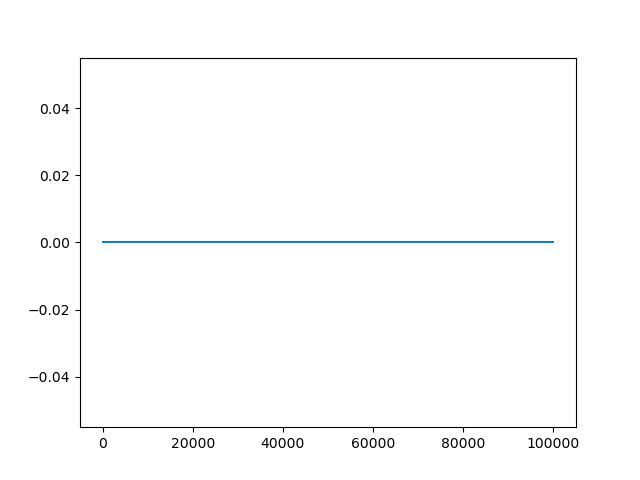

In [33]:
fig, ax = plt.subplots()
ax.plot(sol.t,np.log(np.linalg.norm(dx_t[:,:],axis=0)))

In [34]:
#%%timeit
sol = []
#for inity in [[1,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,1]]:
for inity in [[1,1,1,1,1,1]]:
    inity = {y[i]:el for i, el in enumerate(inity)}
    Y0 = np.float64(xy.subs(initcanon).subs(inity))[:,0]

    t_span = (0,10000)
    sol += [sp.integrate.solve_ivp(func, t_span, Y0, t_eval=np.linspace(*t_span,1000),rtol=1e-9)]

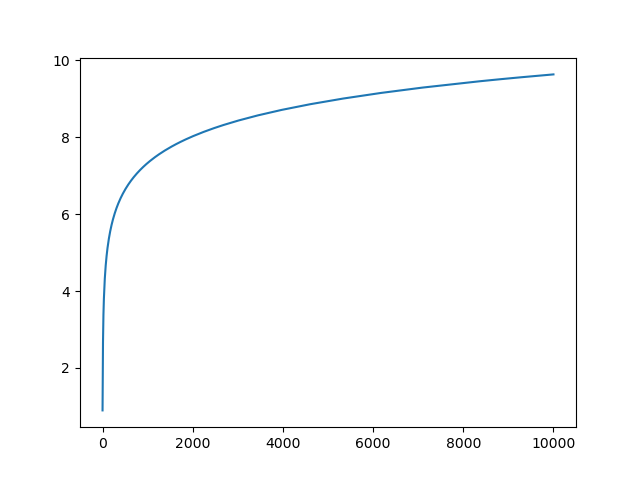

In [35]:
fig, ax = plt.subplots()
for s in sol:
    dx_t = s.y[6:,:]
    ax.plot(s.t,np.log(np.linalg.norm(dx_t[:,:],axis=0)))

# Grid of runs

In [91]:
params = {
    a_p:1,
    e_p:0.,
    mu_p:1e-3,
    pom_p:0.,
    om:0,
    om_p:0,
    f1:f1val_outside,
    f2:f2val_outside,
    j:2,
    "e0":0.01,
    "pom0":np.pi,
}
rhs = RHS.subs(params)
rhs.free_symbols
rhsfunc = lambdify([t,*xy],rhs)
def func(t, Y):
    return rhsfunc(t, Y[0], Y[1], Y[2], Y[3], Y[4], Y[5], Y[6], Y[7], Y[8], Y[9], Y[10], Y[11])[:,0]

In [101]:
def calc_FLIt(p):
    i, av, th2v = p[0], p[1], p[2]
    print(i)
    initorb = {a: av, e: params["e0"], pom: params["pom0"]}
    initorb[l] =  (th2v-params["pom0"]) / (params[j] + 1)
    initcanon = {
        t: 0,
        T: 1,
        l: to_orbelts(l).subs(initorb),
        g: to_orbelts(g).subs(initorb),
        L: to_orbelts(L).subs(initorb),
        G: to_orbelts(G).subs(initorb),
        tau: 0,
    }

    avg_FLI = 0
    for inity in [
        [1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0],
        [0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 1],
    ]:
        inity = np.array(inity, dtype=np.float64)
        inity = {y[i]: el for i, el in enumerate(inity)}

        Y0 = np.float64(xy.subs(initcanon).subs(inity))[:, 0]
        t_span = (0, 2e3)
        sol = sp.integrate.solve_ivp(func, t_span, Y0)
        dx_t = sol.y[6:, :]
        avg_FLI += np.log10(np.linalg.norm(dx_t[:, :], axis=0)[-1])
    return avg_FLI / 6

In [102]:
(1.5)**(2./3)

In [103]:
N_side = 100
jobs = []
TH2V, AV = np.meshgrid(np.linspace(0, 2 * np.pi, N_side), np.linspace(1.26, 1.33, N_side))
for ii in range(len(TH2V.flatten())):
    jobs = jobs + [(ii, AV.flatten()[ii], TH2V.flatten()[ii])]

In [104]:
import os, glob, pathlib
from loky import get_reusable_executor
import dill as pickle

In [105]:
executors_solve_ivp = get_reusable_executor(max_workers=32)
results = list(executors_solve_ivp.map(calc_FLIt, jobs))

0
2
1
3
6
4
5
8
7
10
9


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid val

12
11
14
15
1316

18


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid val

19
17
21
23
20
24


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid val

26
25
22
27
28


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


29
30
31


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


32
33
34
35
36


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


37
38
39
40


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


41
42


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


43


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


44
45


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


46


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


47
48
49


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


50
51


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


52
53
54
55


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


56
57
58


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


59
60
61
62


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


63
64
6566



<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


67


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


68
69
70
71


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


72


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


73
74


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


75


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


76
77


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


78


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


79
81
80


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


82
83
84


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


85
86
87
88


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


89
90


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


91
92
93
94
95


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt


96
97


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


98
99
100


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


101


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


102
103
104


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


105


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


106
107
108


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


109
110
111
112
113
114


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


115
116
117


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


118
120
119
121
122


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid val

123
124
125


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


126
127


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


128
129
130


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


131
132
133


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


134
135


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


136


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


137


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


138
139


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


140
141


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


142


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


143
144
145


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


146
147
148
149


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


150
151
152


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


153
154
155


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


156
157


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


158
159


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


160
161
162


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


163
164
165


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


166
167
168
169


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


170
171


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


172
173
174


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


175
177
176


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


178
179
180


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


181
182
183


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


184
185
186
187


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


188
189
190
191


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


192
193
194
195


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


196
197
198
199
200


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


201


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


202
203


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


204
205


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


206


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


207
208


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


209
210
211
212


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


213
214


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


215
216
217


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


218
219
220


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


221
222
223
224


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


225
226
227


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


228


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


229
230
231
232


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


233
234


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


235
236


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


237


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


238
239


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


240


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


241


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


242
243
244


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


245
246
247
248


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


249
250
251
252


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


253
254
255
256


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


257
258
259


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


260


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


261
262


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


263
264
265


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


266
267


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


268
269


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


270
271
272
273


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


274
275
276
277


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


278
279


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


280
281


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


282
283
284


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


285
287
286
288
289

<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power



290


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


291


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


292
293
294
295


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


296


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


297
298


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


299
300
301


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


302
303
304
305


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


306
307
308
309


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


310
311
312
313
314


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


315
316
317


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


318
319
320


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


321
322


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


323
324
325
326


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


327
328


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


329
330


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


331
332


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


333
334
335
336


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


337
338


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


339


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


340
341


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


342


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


343
344


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


345
346


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


347
348
349

<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power



350


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


351
352

<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power



353
354
355
356
357
358
359


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid val

360
361
362
363
364


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


365
366


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


367
368
369
370


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


371
372
373


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


374
375


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


376
377


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


378
379


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


380
381


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


382
383


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


384


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


385


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


386
387
388


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


389
390


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


391
392


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


393
394
395
396
397


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


398
399
400
401
402


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


403
404
405


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


406


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


407
408


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


409
410
411
412


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


413
414
415
416


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


417
418


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


419
420
421


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


422
423


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


424
425


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


426
427
428
429
430


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


431
432


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


433
434


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


435


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


436
437


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


438


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


439


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt


440
441


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


442


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


443
444


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


445
446
447


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


448
449


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


450
451


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


452
453
454


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


455
456
457


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


458


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


459
460


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


461


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


462
463
464


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


465
466


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


467
468


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


469
470


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


471
472
473
474
475
476


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


477
478


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


479


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


480
481


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


482
483
484


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


485
486


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


487
488


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


489


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


491
490


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


492
493
494
495
496


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt


497
498
499


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


500
501
502


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


503
504
505


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


506


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


507
508
509
510


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid val

511
512
513
514
515
516
517
518
519
520


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


521
522523
524



<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


525
526


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


527
528


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


529
530
531
532
533


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


534


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


535
536
537


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


538
539
540


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


541
542


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


543
544


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


545


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


546
547
548


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


549
550


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


551


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


552
553
554
555
556
557


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


558
559


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


560
561


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


562
563
564


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


565
566


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


567
568
569


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


570
571
572


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


573
574


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


575
576
577


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


578
579


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


580
581


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


582
584
583
585


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


586
587
588
589
590


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


591
592


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


593


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


594


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


595
596
597


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


598
599


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


600
601
602


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


603


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


604
605


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


606
607
608
609


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


611
612
610
613


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


614


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


615
616


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


617
618


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


619
620


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


621
622


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid val

623
624
625


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


626
627
628
629


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


630
631
632
633


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


634
635


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


636


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


637


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


638


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


639
640
641
642


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


643


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


644


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


645
646


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


647
648


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


649
650
651


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


652


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


653
654
655
656


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


657


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


658
659
660
661
662


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


663
664
665


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


666
667
668


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


669
670
671
672


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


673


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


674
675
676
677
678


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


679


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


680
681
682


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


683
684
685
686
687


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


688


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


689
690


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


691
692
693


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


694
695


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


696
697
698


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


699
700


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


701
702
703


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


704
705


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


706
707
708
709
710


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


711
712
713
714
715
716
717
718


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid val

719
720
721
722


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


723
724
725


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


726
727
728


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


729


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


730


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


731
732


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


733


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


734
735
736


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


737


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


738
739


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


740


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


741


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


742
743
744


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


745
746


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


747
748
749
750
751


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


752
753
754


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


755
756


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


757
758
759
760
761


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


762


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


763
764765

766


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


767
768
769


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


770
771


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


772
773
774


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


775
776


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


777
778


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


779
780
781
782


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


783
784
785
786
787


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


788
789
790
791


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


792
793


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


794
795
796


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


797
798
799


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


800


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


801
802
803804



<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


805


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


806
807
808
809
810
811
812
813
814


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


815
816


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


817
818


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


819
820
821


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


822
823


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


824
825
826


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


827
828
829
830


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


831
832
833


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


834


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


835
836


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


837
838
839


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


840


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


841


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


842


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


843


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


844


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


845


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


846
847
848
849


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt


850


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


851
852
853
854
855
856
857


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid val

858
859
860
861


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


862
863
864


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


865


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


866


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


867
868
869
870


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


871


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


872
873
874


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


875
876


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


877
878
879
880
881
882


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


883
884


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


885
886
887
888


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


889
890
891
892


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


893
894
895


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


896
897
898
899


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


900


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


901


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


902
903


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


904


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


905


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


906
907
908
909
910
911
912
913
914
915
916
917
918


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


919
920


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid val

921
922
923
924


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


925
926


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


927
928


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


929
930
931


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


932
933


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


934
935


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


936


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


937


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


938
939
940


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


941


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


942


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


943
944


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


945


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


946


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


947
948
949
950


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


951
952
953
954


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


955
956
957
958
959


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt


960
961


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


962


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


963
964


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


965
966
967
968


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


969
970


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


971
972
973


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


974
975


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


976
977978

979


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


980


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


981
982


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


983
984
985
986
987
988


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


989
990
991


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


992


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


993
994


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


995
996
997
998
999
1000
1001

<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1002
1003

<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1004
1005
1006
1007


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1008
1009
1010
1011
1012
1013
1014
1015


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid val

1016
1017
1018
1019


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1020
1021
1022
1023


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt


1024
1025
1026
1027
1028


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid val

1029
1030


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1031
1032
1033
1034
1035


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1036


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1037


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1038
1039


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1040
1041
1042
1043
1044


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1045


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1046


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1047
1048
1049


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1050
1051
1052


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1053
1054
1055
1056


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1057
1058
1059


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1060
1061


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1062


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1063
1064
1065
1066


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1067
1068


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1069
1070
1071


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1072
1073


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1074


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1075
1076
1077
1078


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1079


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1080
1081


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1082
1083


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1084
1085
1086
1087
1088


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1089
1090


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1091


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1092
1093


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1094
1095


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1096
1097
1098


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1099
1100


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1101


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1102
1103


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1104
1105
1106
1107
1108


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1109
1110
1111
1112
1113
1114


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1115
1116
1117


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid val

1118
1119


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1120
1121
1122


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1123
1124
1125
1126


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1127


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1128
11291130

1131


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1132
1133
1134


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1135
1136
1137


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1138
1139


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1140
1141


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1142


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1143


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1144


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1145


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1146


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1147


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1148
1149
1150
1151


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1152
1153
1154
1155
1156
1157


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid val

1158
1159
1160
1161
1162
1163


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1164
1165


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1166
1167
1168


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1169
1170


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1171


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1172
1173


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1174
1175

<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power



1176
1177


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1178
1179
1180


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1181
1182


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1183
1184
1185


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1186
1187
1188
1189


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1190
1191
1192
1193
1194
1195


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1196


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1197
1198
1199
1200


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1201


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1202
1203


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1204
1205
1206
1207
1208
1209
1210
1211
1212
1213
1214


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1215
1216
1217
1218
1219
1220


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1222
1221
1223
1224
1225


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1226
1227


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1228


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1229


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1230
1231
1232


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1233


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1234
1235


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1236
1237


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1238


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1239
1240
1241
1242
1243


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1244


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1245
1246


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1247
1248
1249
1250


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1251
1252
1253

<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power



1254
1255
1256
1257


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1258
1259
1260
1261


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1262
1263


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1264
1265
1266


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1267
1268
1269
1270
1271
1272


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1273


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1274


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1275


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1276
1277
1278


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1279
1280
1281
1282


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1283
1284


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1285
1286
1287


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1288
1289
1290


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1291
1292
1293
1294
1295


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1296
1297


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1298
1299
1300
1301


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1302
1303


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1304
1305
1306
1307
1308
1309
1310
1311


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1312
1313
1314
1315
1316
1317


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid val

1318
1319
1320


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1321
1322
1323
1324


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1325
1326


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1327


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1328


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1329
1330


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1331
1332
1333


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1334
1335


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1336


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1337
1338
1339


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1340
1341
1342


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1343
1344
1345


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1346


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1347
1348


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1349
1350
1351
1352


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1353
1354
1355
1356
1357


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1358
1359
1360
1361


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1362
1363
1364
1365


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1366


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1367
1368
1369


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1370
1371
1372


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1373
1374


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1375
1376


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1377
1378
1379


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1380
1381
1382
1383
1384


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1385
1386
1387


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1388
1389
1390
1391
1392
1393


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1394
1395
1396


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1397


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1398


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1399


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1400


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1401
1402


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1403


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1404
1405
1406
1407
1408
1409


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1410
1411
1412
1413
1414


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1415
1416
1417
1419
1418
1420


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1421


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1422
1423


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1424


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1425
1426


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1427
1428


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1429
1430


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1431
1432


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1433


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1434
1435


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1436
1437


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1438
1439


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1440
1441


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1442
1443


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1444


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1445


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1446


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1447
1448
1449
1450


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1451
1452


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1453
1454
1455
1456


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1457
1458
1459
1460
1461


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1462
1463


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1464
1465
1466
1467


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1468
1469
1470


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt


1471
1472


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1473


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1474
1475
1476


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1477
1478
1479


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1480
1481


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1482
1483
1484


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1485
1486


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1487
1488


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1489
1490
1491


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1492
1493


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1494
1495


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1496
1497
1498


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1499
1500


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1501


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1502
1503


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1504
1505
1506
1507


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1508
1509
1510
1511
1512
1513
1514


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1515
1516


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1517
1518
1519


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt


1520
1521
1522
1523


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1524
1525
1526


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1527
1528


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1529


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1530
1531
1532
1533


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1534
1535


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1536


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1537
1538
1539


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1540
1541
1542


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1543
1544
1545
1546


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1547


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1548
1549
1550


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1551


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1552
1553
1554


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1555
1556
1557
1558
1559


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1560
1561


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1562


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1563
1564
1565
1566
1567
1568
1569


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid val

1570
1571


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1572
1573


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1574
1575


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1576
1577
1578
1579


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1580


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1581


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1582
1583
1584
1585


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1586
1587
1588
1589


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1590
1591
1592


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1593
1594
1595


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1596
1597
1598


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1599
1600


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1601


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1602
1603


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1604
1605
1606


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1607
1608
1609
1610
1611
1612


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1613
1614
1615
1616


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid val

1617
1618
1619
1620
1621
1622


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1623
1624
1625


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1626


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1627
1628


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1629
1630


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1631
1632
1633


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1634


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1635


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1636
1637
1638


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1639
1640


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1641
1642
1643


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1644


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1645


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1646


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1647
1648
1649
1650


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1651
1652
1653
1654
1655


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1656


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1657
1658
1659


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1660


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1661
1662
1663
1664
1665
1666


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1667
1668
1669
1670
1671


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1672


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1673


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1674
1675
1676
1677


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1678
1679


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1680
1681
1682
1683


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1684
1685
1686


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt


1687


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1688
1689
1690
1691
1692
1693


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1694


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1695
1696


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1697


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1698
1699
1700
1701


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1702


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1703
1704
1705
1706
1707
1708
1709
1710
1711
1712
1713
1714


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1715
1716
1717


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1718
1719


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1720
1721
1722
1723


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1724
1725


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1726
1727


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1728
1729
1730


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1731
1732
1733


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1734
1735


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1736
1737


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1738
1739


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1740
1741
1742


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1743


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1744


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1745
1746


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1747
1748
1749


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1750
1751
1752
1753
1754
1755

<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power



1756
1757


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1758
1760
1759
1761
1762


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1763
1764
1765


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1766
1767
1768
1769


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1770
1771
1772


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1773
1774


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1775


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1776
1777


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1778


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1779
1780
1781
1782


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt


1783
1784


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1785
1786
1787
1788


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1789
1790
1791


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1792
1793
1795
1794


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1796
1797


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1798
1799
1800
1801


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1802


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1803
1804


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1805
1806
1807
1808
1809
1810


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1811
1812
1813
1814


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid val

1815
1816
1817
1818


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1819
1820
1821
1822
1823
1824
1825


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1826
1827


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1828
1829
1830


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1831


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1832


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1833
1834
1835
1836


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1837
1838


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1839
1840


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1841
1842
1843


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1844


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1845
1846


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1847
1848
1849


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1850


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1851
1852
1853


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1854
1855
1856


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1857


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1858
1859
1860
1861
1862


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1863
1864


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1865
1866
1867


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1868


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1869
1870


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1871


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1872
1873


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1874


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1876
1875
1877


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1878
1879
1880


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1881
1882


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1883
1884
1885


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1886
1887
1888


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1889
1890


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1891
1892
1893
1894


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1895


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1896
1897


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1898
1899
1900


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1901
1902
1903


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1904
1905
1906
1907
1908
1909
1910
1911


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1912
1913


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


19141915

1916
1917
1918
1919


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1920
1921


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1922
1923
1924
1925


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1926


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1927
1928
1929


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1930
1931
1932
1933
1934


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1935


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1936
1937
1938


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1939
1940


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1941


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1942
1943


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1944
1945


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1946


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1947


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1948
1949


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1950
1951
1952
1953
1954
1955
1956


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid val

1957
1958
1959


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1960
1961
1962


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1963
1964
1965


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1966


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1967
1968
1969
1970
1971
1972


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1973
1974
1975


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1976


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1977


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1978
1979
1980
1981


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1982


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1983
1984
1985


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1986
1987
1988
1989


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1991
1990


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1992
1993
1994


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


1995
1996
1997
1998


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt


1999
2000
2001


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2002


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2003


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2004


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2017
2018
2019
2020


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid val

2021
2022
2023


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2024
2025
2026
2027


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid val

2028
2029


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid val

2030
2031
2032


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2033
2034
2035


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2036


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2037
2038
2039
2040


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2041
2043
2042


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2044
2045


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2046


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2047


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2048
2049
20502051

2052
2053
2054


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid val

2055
2056
2057


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2058


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2059
2060
2061


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2062
2063
2064
2065


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2066
2067
2068
2069
2070
2071


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid val

2072
2073
2074
2075


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2076


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2077
2078


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2079
2080
2081
2082
2083


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2084
2085
2086


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2087
2088
2089


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2090
2091
2092


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2093


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2094
2095
2096


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2097
2098
2099


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2100


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2101
2102
2103


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2104
2105
2106
2107
2108
2109
2110
2111
2112


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2113
2114


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2115
2116


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2117
2118


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2119
2120
2121
2122


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid val

2123
2124
2125
2126
2127


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2128
2129
2130


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2131
2132


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2133
2134


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2135
2136
2137
2138
2139


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid val

2140
2141
2142
2143


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2144


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2145


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2146


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2147
2148
2149
2150


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2151


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2152
2153
2154
2155
2156
2157


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2158
2159
2160

<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power



2161
2162


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2163
2164

<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power



2165
2166
2167
2168


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2169
2170


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2171
2172
2173


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2174


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2175
2176
2177
2178


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2179
2180
2181
2182
2183
2184


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid val

2185
2186


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2187
2188
2189
2190
2191
2192
2193


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2194
2195


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2196
2197
2198


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2199
2200


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2201
2202
2203
2204
2205
2206


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt


2207
2208
2209
2210


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2211
2212


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2213
2214
2215
2216
2217


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2218
2219
2220
2221


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt


2222
2223
2224


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2225


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2226
2227


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2228


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2229
2230


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2231
2232
2233


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2234
2235
2236


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2237
2238
2239


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2240
2241


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2242


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2243


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2244


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2245


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2246


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2247


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2248
22492250



<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2251
2252
2253
2254
2255
2256


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2257
2258


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2259
2260
2261


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2262
2263
2264
2265
2266
2267


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid val

2268
2269
2270


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2271
2272
2273
2274


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2275
2276
2277


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2278


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2279
2280
2281
2282
2283


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2284
2285
2286
2287


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2288
2289
2290
2291
2292
2293


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2294


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid val

2295
2296
2297
2298
2299


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2300


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2301
2302
2303
2304

<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2305
2306
2307


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2308
2309
2310
2311
2312
2313
2314


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2315
2316
2317


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2318
2319
2320


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2321
2322


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2323
2324
2325
2326


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2327
2328


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2329
2330
2331


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2332
2333


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2334
2335
2336


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2337
2338
2339


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2340
2341


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2342


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2343
2344


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2345
2346


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2347
2348
2349


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2350
2351
2352
2353


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2354
2355
2356
2357
2358


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2359
2360
2361


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2362
2363
2364
2365
2366


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2367
2368


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2369
2370


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2371


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2372
2373
2374


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2375
2376
2377
2378


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2379
2380
2381
2382


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2383
2384
2385
2386
2387
2388


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2389
2390
2391
2392
2393


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2394
2395
2396


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2397
2398


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2399
2400


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2401
2402
2403
2404
2405


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2406
2407
2408
2409
2410
2411
2412
2413
2414
2415


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid val

2416
2417


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2418
2419
2420


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid val

2421
2422
2423
2424
2425
2426


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2427
2428
2429


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2430
2431
2432
2433


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2434
2435
2436
2437


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2439
2438
2440
2441
2442


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2443


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2444
2445


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2446


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2447
2448


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2449
2450
2451


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2452
2453
2454
2455


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2456
2457
2458
2459
2460
2461


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid val

2462
2463
2464
2465


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2466
2467
2468
2469
2470


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2471
2472
2473


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2474
2475


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2476


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2477
2478


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2479
2480


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2481
2482


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2483
2484
2485
2486
2487
2488

<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power



2489
2490
2491
2492


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2493
2494
2495


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2496
2497


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2498
2499


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2500
2501


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2502


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2503


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2504
2505
2506


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2507
2508
2509
2510
2511
2512
2513
2514
2515


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2516
2517
2518
2519


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2520
2521
2522


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2523
2524
2525


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2526
2527


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2528
2529
2530
2531
2532
2533


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2534


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2535


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2536
2537
2538


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2539
2540
2541


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2542
2543
2544


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2545
2546


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2547


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2548


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2549
2550
2551
2552
2553
2554
2555


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid val

2556
2557
2558
2559
2560
2561
2562


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid val

2563
2564
2565
2566


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2567
2568
2569
2570


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2571
2572
2573


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2574
2575


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2576
2577
2578


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2579
2580
2581


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2582
2583


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2584


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2585
2586
2587
2588


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2589
2591
2590
2592
2593
2594
2595
2596


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid val

2597


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2598


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2599


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2600
2601


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2602
2603


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2604
2605
2606
2607


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2608
2609
2610
2611
2612
2613
2614


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2615
2616
2617
2618


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2619
2620
2621
2622


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2624
2623
2625
2626


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2627
2628


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2629
2630


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2631
2632


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2633
2634


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2635
2636
2637


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2638
2639
2640


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2641
2642


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2643
2644


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2645
2646


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2647
2648


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2649
2650
2651
2652


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2653
2654
2655
2656
2657


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2658
2659
2660


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2661
2662
2663
2664
2665
2666


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid val

2667
2668
2669
2670


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2671
2672
2673


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2674


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2675
2676
2677
2678
2679
2680


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2681
2682
2683


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2684
2685


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt


2686
2687
2688
2689


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2690
2691
2692
2693
2694


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


26952696



<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2697


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2698
2699


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2700
2701


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2702


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2703


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2704
2705
2706
2707


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2708
2709
2710
2711
2712
2713
2714


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2715
2716
2717
2718
2719
2720


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid val

2721
2722
2723


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt


2724
2725


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2726
2727
2728
2729
2730


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2731
2732


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2733
2734
2735
2736


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2737
2738
2739


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2740


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2741
2742
2743


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2744
2745


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2746
2747


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2748
2749


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2750
2751
2752


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2753
2754
2755


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2756
2757
2758
2759
2760
2761


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2762
2763


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2764
2765
2766
2767


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2768
2769
2770


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2771
2772
2773


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2774
2775
2776
2777


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2778


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2779
2780
2781
2782
2783
2784
2785


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid val

2786
2787
2788
2789
2790


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2791
2792
2793


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2794
2795
2796


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2797
2798


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2799


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2800


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2801
2802


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2803
2804
2805
2806
2807


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2808
2810
2809
2811
2812


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2813
2814


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2815
2816
2817
2818
2819


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2820
2821


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2822
2823
2824


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2825
2826
2827


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2828
2829


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2830
2831
2832
2833
2834


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2835
2836
2837


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2838
2839
2840
2841
2842


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2843


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2844


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2845
2846
2847


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2848
2849


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2851
2852
2850
2853
2854
2855
2856
2857
2858


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid val

2859
2860
2861
2862
2863


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid val

2864
2865
2866
2867
2868


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2869
2870
2871


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2872
2873
2874


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2875
2876


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2877
2878
2879


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2880
2881
2882
2883
2884
2885
2886


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid val

2887
2888
2889
2890
2891


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2892
2893


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2894
2895


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2896
2897
2898
2899
2900
2901


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2902


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2903


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2904
2905
2906
2907


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid val

2908
2909
2910
2911
2912
2913
2914


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2915
2916


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2918
2917
2919
2920
2921
2922
2923
2924


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2925
2926
2927


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2928
2929


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2930
2931
2932
2933
2934

<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power



2935
2936
2937
2938


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2939
2940


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2941
2942


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2943
2944
2945


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2946
2947
2948
2949


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2950
2951


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2952
2953


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2954
2955
2956
2957
2958


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2959
2960


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2961
2962
2963
2964
2965


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2966


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2967
2968
2969


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2970
2971
2972
2973
2974


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2975
2976
2977


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2978
2979


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2980


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2981
2982
2983
2984
2985
2986
2987
2988


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid val

2989
2990
2991


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2992
2993
2994
2995


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


2996
2997
2998

<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power



2999
3000
3001
3002


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3004
3003
3005
3006
3007


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3008
3009


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3010
3011
3012
3013
3014
3015
3016


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid val

3017
3018
3019
3020
3021
3022
3023


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid val

3024
3025
3026
3027
3028


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3029
3030
3031


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3032
3033
3034


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3035


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3036
3037


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3038
3039
3040


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3041
3042


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3043
3044

<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power



3045
3046
3047
3048
3049


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3050
3051
3052
3053


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3054
3055
3056


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3057
3058
3059
3060
3061


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3062
3063
3064
3065


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3066
3067
3068
3069
3070


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3071
3072
3073


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3074


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3075
3076


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3077
3078
3079
3080


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3081
3082
3083
3084
3085
3086
3087


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid val

3088
30903089



<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3091
3092
3093
3094
3095


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid val

3096
3097
3098


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt


3099
3100


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3101
3102
3103


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3104
3105
3106
3107


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3108
3109
3110
3111
3112
3113
3114


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid val

3115
3116
3117
3118
3119
3120
3121


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid val

3122
3123
3124
3125
3126
3127


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3128
3129
3130
3131


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3132
3133
3134
3135


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3136


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3137
3138
3139


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3140
3141


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3142


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3143
3144
3145
3146
3147
3148


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid val

3149
3150
3151
3152
3153
3154


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3155
3156
3157


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3158
3159
3160
3161

<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power



3162
3163
3164
3165
3166
3167


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3168
3169
3170
3171


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3172


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3173
3174
3175
3176


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


31773178



<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3179
3180


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3181
3182
3183


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3184
3185
3186
3187


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3188
3189


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3190
3191


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3192
3193
3194
3195
3196
3197


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3198
3199
3200


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3201
3202
3203
3204


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3205
3206
3207
3208
3209
3210


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3211
3212
3213


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3214
3215
3216
3217


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3218
3219
3220
3221
3222
3223
3224


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3225
3226
3227
3228


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3229
3230
3231
3232
3233
3234


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3235
3236
3237
3238


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3239


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3240
3241


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3242
3243


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3244
3245


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3246
3247


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3248


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3249


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3250
3251
3252
3253


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3254
3255
3256
3257
3258


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3259
3260
3261
3262
3263


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3264
3265


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3266
3267
3268
3269
3270


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3271
3272
3273
3274
3275
3276


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid val

3277
3278


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3279
3280


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3281
3282
3283


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3284
3285
3286
3287
3288
3289


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3290
3291


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3292
3293


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3294
3295
3296
3297
3298


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3299


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3300
3301
3302


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3303
3304
3305
3306
3307
3308


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3309
33103311
3312

3313


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3314
3315
3316
3317
3318
3319


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid val

3320
3321
3322


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3323
3324
3325
3326
3327
3328


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3329
3330
3331


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3332
3333
3334


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3335
3336
3337


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3338
3339
3340
3341


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3342


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3343


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3344
3345


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3346
3347


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3348


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3349
3350
3351
3352
3353


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3354
3355


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3356
3357
3358
3359
3360
3361
3362


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid val

3363
3364
3365
3366
3367
3368

<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt



3369


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3370
3371
3372
3373


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3374
3376
3375


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3377
3378
3379


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3380
3381
3382
3383


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3384
3385


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3386
3387


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3388
3389
3390
3391
3392


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3393
3394
3395
3396
3397
3398


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid val

3399
3400
3401


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3402
3403
3404
3405
3406


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3407
3408


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3409
3410
3411
3412
3413


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3414
3415
3416
3417
3418


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid val

3419
3420
3421
3422
3423
3424
3425
3426


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3427
3428
3429


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3430
3431
3432


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3433
3434
3435
3436
3437


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3438


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3439
3440


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3441
3442
3443


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3444
3445
3446


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3447
3448
3449


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3450
3452
3451


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt


3453
3454
3455
3456
3457
3458


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3459
3460
3461
3462
3463


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3464
3465
3466
3467
3468
3469


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3470
3471
3472


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3473
3474
3475


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3476
3477


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3478
3479


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3480
3481


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3482
3483


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3484
3485


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3486
3487
3488
3489


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3490
3491
3492


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3493
3494
3495
3496


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3497
3498
3499
3500
3501


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3502
3503
3504


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3505


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3506
3507
3508
3509

<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt



3510
3511
3512
3513
3514
3515


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid val

3516
3517
3518
3519
3520

<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid val


3521
3522
3523
3524
3525
3526

<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power



3527
3528
3529
3530


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3531
3532
3533
3534


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3535
3536


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3537
3538


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3539


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3540
3541
3542


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3543


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3544


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3545
3546


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3547
3548
3549
3550
3551


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3552
3553
3554
3555


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3556


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3557
3558
3559
3560
3561
3562


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3563
3564


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3565
3566
3567
3568
3569
3570


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid val

3571
3572


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3573
3574
3575
3576


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3577
3578


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3579
3580
3581
3582


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3583
3584
3585


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3586
3587
3588


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3589
3590
3591
3592


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3593
3594
3595


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3596
3597
3598


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3599


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3600
3601
3602


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3603
3604


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3605
3606


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3607
3608
3609
3610


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3611
3612
3613
3614
3615
3616


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3617
3618
3619
3620
3621


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3622
3623
3624
3625
3626
3627
3628
3629


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid val

3630
3631


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3632
3633
3634


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3635
3636
3637
3638


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3639
3640


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3641
3642


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3643
3644


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3645
3646


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3647


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3648
3649
3650


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3651
3653
3652
3654
3655


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3656
3657
3658
3659


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3660
3661
3662
3663
3664
3665
3666


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid val

3667
3668
3669
3670
3671


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3672


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3673
3674


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3675
3676
3677


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3678
3679
3680
3681
3682


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3683
3684
3685
3686


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3687
3688


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3689
3690
3691
3692
3693


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3694
3695
3696
3697


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3698
3699


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3700
3701
3702


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3703
3704


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3705
3706


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3707
3708
3709


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3710
3711


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3712
3713
3714
3715
3716
3717
3718
3719


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid val

3720
3721
3722
3723
3724
3725


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid val

3726
3727
3728
3729


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3730
3731
3732


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3733
3734
3735


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3736
3737


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3738
3739


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3740
3741
3742


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3743
3744


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3745


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3746
3747


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3748
3749
3750
3751
3752


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3753
3754
3755


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3756
3757
3758
3759
3760


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3761
3762
3763
3764
3765


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3766
3767
3768
3769
3770


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3771
3772
3773


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3774


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3775
3776


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3777
3778


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3779
3780
3781
3782


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3783
3784
3785


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3786
3787


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3788
3789


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3790
3791
3792


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3793
3794


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3795
3796
3797
3798


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3799
3800
3801


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3802
3803


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3804


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3805
3806
3807


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3808
3809
3810
3811


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3812
3813
3814
3815
3816
3817

<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power



3818
3819


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3820
3821
3822
3823
3824
3825
3826
3827


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3828
3829


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3830
3831


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3832
3833
3834
3835


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3836
3837


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3838
3839


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3840
3841


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3842
3843
3844


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3845
3846


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3847
3848


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3849
3850
3851


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3852
3853
3854
3855
3856
3857


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3858
3859
3860


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3861
3862
3863
3864


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3865
3866


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3867
3868
3869


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3870


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3871
3872
3873


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3874
3875
3876


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3877
3878
3879


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3880
3881
3882
3883


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3884
3885
3886


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3887
3888
3889
3890
3891


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3892
3893
3894


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3895
3896
3897
3898


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3899
3900


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3901
3902


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3903


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3904
3905


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3906
3907
3908
3909
3910


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3911
3912
3913
3914


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3915
3916
3917
3918
3919
3920
3921
3922
3923


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3924
3925
3926


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3927
3928
3929
3930


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3931
3932
3933
3934
3935


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3936
3937
3938


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3939


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3940


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3941
3942
3943


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3944
3945


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3946
3947


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3948
3949
3950
3951


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3952
3953
3954
3955


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3956
3957
3958
3959
3960


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3961
3962
3963
3964
3965
3966


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3967
3968
3969


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3970
3971
3972


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3973
3975
3974


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3976
3977
3978

<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt



3979


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3980
3981
3982


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3983
3984
3985
3986


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3987
3988


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3989


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3990
3991


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3992
3993
3994


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3995
3996


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


3997
3998
3999
4000


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4001
4002
4003


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4004


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4005
4006


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4007
4008
4009
4010
4011


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4012


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4013
4014


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4015
4016
4017
4018
4019
4020


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4021
4022
4023
4024


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4025
4026
4027
4028
4029


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4030
4031
4032


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt


4033
4034
4035


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4036


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4037
4038
4039


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4040
4041


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4042
4043


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4044
4045


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4046
4047


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4048
4049
4050


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4051
4052
4053
4054
4055


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4056
4057
4058
4060
4059
4061


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid val

4062
4063
4064
4065
4066
4067
4068


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4069
4070
4071


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4072
4073

<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power



4074
4075
4076


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4077
4078
4079
4080


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4081
4082
4083
4084
4085


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4086
4087


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4088
4089


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4090
4091
4092


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4093
4094
4095
4096
4097


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4098
4099


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4100
4101


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4102
4103


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4104
4105
4106


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4107


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4108
4109
4110
4111
4112


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4113
4114
4115
4116
4117
4118


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid val

4119
4120
4121
4122


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4123
4124


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4125
4126


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4127
4128
4129


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4130
4131
4132


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4133
4134
4135
4136
4137
4138


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4139


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4140
4141
4142


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4143


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4144
4145
4146


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4147
4148


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4149
4150
4151
4152


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4153
4154
4155
4156
4157
4158


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4159
4160
4161
4162
4163


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4164
4165
4166
4167


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4168
4169
4170
4171
4172


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4173


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4174
4175
4176
4177
4178


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4179


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4180
4181
4182
4183


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt


4184
4185
4186
4187


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4188
4189


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4190
4191
4192
4193
4194


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4195
4196
4197
4198


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4199
4200
4201

<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power



4202
4203


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4204


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4205
4206
4207
4208


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt


4209
4210
4211


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4212
4213
4214
4215
4216


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4217
4218
4219
4220
4221
4222
4223
4224
4225

<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid val


4226
4227
4228
4229


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt


4230
4231
4232
4233


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4234
4235


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4236


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4237


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4238
4239
4240
4241
4242


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4243
4244
4245
4246


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4247


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4248
4249
4250


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4251
4252
4253
4254
4255
4256


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4257
4258


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4259
4260
4261
4262
4263
4264


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4265
4266


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


42674268

4269
4270
4271
4272
4273
4274


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid val

4275
4276


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4277
4278
4279


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4280
4281
4282


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4283


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4284


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4285
4286
4287


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4288
4289
4290
4291
4292
4293


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4294
4295


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4296
4297


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4298
4299
4300


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4301
4302


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4303
4304


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4305
4306


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4307
4308
4309
4310
4311
4312
4313


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid val

4314
4315
4316
4317


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt


4318
4319
4320
4321
4322
4323
4324


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid val

4325
4326
4327
4328

<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power



4329
4330
4331
4332
4333


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4334


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4335
4336


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4337
4338
4339


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4340
4341


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4342
4343
4344
4345
4346


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4347
4348


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4349
4350


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4351
4352
4353


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4354
4355
4356
4357
4358
4359


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid val

4360
4361
4362


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4363
4364

<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power



4365


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4366
4367


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4368
4369
4370
4371
4372
4373
4374


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4375
4376
4377
4378


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4379
4380


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4381
4382
4383


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4384
4385


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4386


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4387
4388
4389
4390
4391


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4392
4393


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4394


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4395


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4396
4397
4398


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4399
4400


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4401
4402
4403

<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power



4404
4405
4406
4407


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4408
4409
4410
4411


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4412
4413
4414
4415


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4416
4417
4418
4419
4420


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4421
4422
4423
4424
4425


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid val

4426
4427
4428


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4430
4429
4431


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4432
4434
4435
4433


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4436


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4438
4437
4439
4440
4441


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4442
4443


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4444
4445

<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power



4446
4447


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4448
4449


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4450
4451


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4452
4453
4454
4455


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4456
4457
4458
4459
4460


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4461
4462
4463
4464


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4465
4466
4467
4468
4469


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4470
4471
4472
4473
4474
4475


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4476
4477


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4478
4479


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4480
4481
4483
4482
4484


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid val

4485
4486
4487


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4488
4489
4490


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4491
4492
4493
4494


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4495
4496
4497


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4498
4499


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4500
4501
4502
4503


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4504
4505
4506


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4507
4508
4509


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4510
4511
4512
4513
4514


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4515
4516
4517


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4518
4519
4520
4521
4522
4523


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4524
4525
4526


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4527


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4528
4529


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4530
4531
4532
4533


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid val

4534
4535
4536
4537
4538
4539


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4540


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4541
4542


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4543
4544


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4545
4546


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4547


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4548


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4549
4550
4551


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4552
4553
4554
4555


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4556
4557
4558
4559
4560
4561

<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power



4562
4563
4564
4565
4566
4567
4568


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid val

4569
4570
4571
4572


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4573
4574


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4575


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4576
4577


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4578
4579
4580
4581


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4582
4583
4584
4585


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4586
4587


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4588
4589
4590


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4591
45924593

4594
4595


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4596
4597


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4598
4599


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4600
4601
4602
4603
4604


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4605
4606


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4607


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4608


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4609
4610


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4611
4612
4613
4614
4615


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4616
4617
4618
4619
4620
4621


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4622
4623
4624
4625
4626


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4627
4628
4629
4630
4631


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4632
4633
4634
4635


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4636
4637


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4638


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4639
4640


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4641


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4642
4643


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4644
4645
4646


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4647
4648
4649


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4650
4651
4652
4653
4654
4655
4656
4657


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid val

4658
4659
4660
4661
4662


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4663
4664
4665


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4666
4667
4668
4669


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4670


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4671
4672


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4673


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4674
4675
4676
4677
4678
4679


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4680
4681
4682


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4683


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4684
4685
4686


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4687
4688
4689
4690


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4691
4692
4693
4694


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4695
4696


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4697


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4698
4699
4700


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4701
4702


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4703
4704


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4705
47064707

4708


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4709
4710
4711
4712


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid val

4713
4714
4715
4716
4717
4718


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4719
4720
4721
4722


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4723
4724
4725


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4726
4727
4728
4729


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4730
4731
4732
4733


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4734
4735
4736


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4737
4738
4739


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4740
4741
4742


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4743
4744


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4745
4746


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4747
4748


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4749
4750
4751
4752


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4753
4754
4755
4756


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4757
4758

<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power



4759
4760
4761
4762


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt


4763
4764
4765


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4766
4767
4768


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4769
4770
4771
4772
4773


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4774
4776
4775


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4777


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4778
4779
4780
4781
4782


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid val

4783
4784
4785


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4786
4787
4788


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4789
4790
4791


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4792
4793


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4794


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4795
4796


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4797
4798


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4799


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4800
4801


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4802
4803
4804


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4805
4806
4807
4808


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4810
4809
4811
4812
4813

<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power



4814
4815
4816
4817


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4818
4819
4820


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4821
4822
4823


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4824
4825
4826


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4827
4828


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4829


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4830
4831
4832


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4833
4834


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4835
4836
4837


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4838
4839


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4840
4841


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4842
4843
4844


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4845
4846


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4847


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4848
4849

<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power



4850


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4851


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4852
4853
4854
4855


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4856
4857
4858
4859
4860
4861
4862

<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid val


4863
4864
4865
4866


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4867
4868
4869
4870
4871
4872

<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power



4873
4874


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4875
4876
4877


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt


4878
4879


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4880
4881
4882
4883


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4884
4885


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4886
4887


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4888
4889
4890
4891
4892


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4893
4894
4895


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4896
4897


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4898
4899
4900


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4901
4902
4903


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4904
4905


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4906
4907
4908


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4909


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4910


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4911
4912
4913
4914
4915
4916


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4917
4918
4919
4920
4921
4922


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4923
4924
4925
4926


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4927
4928


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4929
4930
4931


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4932
4933
4934
4935


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


49364937

4938
4939
4940


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4941


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4942
4943


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4944
4945
4946


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4947


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4948
4949
4950
4951
4952
4953


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4954
4955
4956
4957
4958


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4959
4960
4961


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4962
4963
4964
4965


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4966
4967


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4968
4969
4970


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4971
4972


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4973
4974
4975


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4976
4977


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4978
4979
4980
4981
4982
4983


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4984
4985
4986
4987
4988
4989


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4990


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4991
4992
4993


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4994
4995


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4996
4997


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


4998
4999
5000


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5001
5002


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5003
5004
5005


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5006
5007


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5008
5009
5010


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5011
5012
5013
5014


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5016
5015
5017
5018
5019
5020

<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power



5021
5022
5023
5024


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5025
5026


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5027
5028
5029


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5030
5031
5032


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5033


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5034
5035
5036


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5037


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5038
5039


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5040
5041
5043
5042


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5044
5045


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5046
5047
5048


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5049


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5050
5051


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5052
5053


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5054
5055
5056
5057
5058
5059
5060


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid val

5061
5062
5063


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5064
5065
5066
5067
5068


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5069
5070
5071
5072
5073
5074
5075

<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid val


5076


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5077
5078
5079
5080


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5081


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5082
5083


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5084
5085


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5086
5087
5088
5089


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5090
5091
5092


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5093
5094
5095
5096


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5097
5098
5099


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5100
5101


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5102
5103


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5104
5105
5106


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5107
5108
5109
5110


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5111
5112
5113


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5114
5115
5116
5117
5118


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid val

51205119

5121


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5122
5123
5124
5125


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5126
5127
5128


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5129
5130
5131


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5132


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5133
5134
5135


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5136
5137


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5138
5139
5140


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5141
5142
5143


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5144
5145


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5146
5147


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5148
5149


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5150
5151
5152


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5153
5154


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5155
5156
5157
5158


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5159
5160
5161


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5162
5163
5164


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5165
5166
5167
5168
5169


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5170
5171
5172


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5173
5174


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5175


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5176
5177


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5178
5179
5180
5181
5182


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5183
5184


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5185
5186
5187


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5188
5189


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5190
5191
5192


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5193
5194


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5195
5196


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5197


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5198
5199


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5200


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5201


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5202
5203
5204
5205


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5206
5207
5208
5209


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5210
5211
5212
5213
5214
5215


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid val

5216
5217
5218
5219


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5220
5221
5222


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5223
5224
5225
5226


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5227


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5228
5229


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5230
5231
5232


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5233
5234
5235
5236
5237
5238


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5239
5240


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5241


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5242
5243


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5244
5245
5246
5247


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5248


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5249
5250


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5251
5252
5253
5254
5255


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5256
5257
5258
5259
5260
5261


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5262
5263
5264
5265
5266


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5267
5268
5269
5270


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5271
5272
5273
5274


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt


5275
5276
5277


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5278
5279
5280
5281


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5282


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5283
5284
5285


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5286
5287
5288


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5289


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5290
5291


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5292
5293
5294
5295
5296
5297


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5298
5299
5300


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5301
5302


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5303


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5304
5305
5306


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5307
5308
5309


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5310
5311
5312
5313
5314
5315


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5316
5317
5318
5319


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5320
5321
5322
5323
5324
5325


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5326
5327


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5328
5329
5330
5331
5332


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5333


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5334
5335


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5336
5337
5338


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5339
5340
5341


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5342


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5343
5344
5345


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5346
5347


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5348
5349


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5350
5351
5352
5353
5354


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid val

5355
5356
5357
5358
5359
5360


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5361
5362
5363


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5364
5365
5366
5367


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5368
5369
5370
5371
5372


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5373
5374


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5375
5376


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5377
5378
5379


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5380
5381
5382


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5383
5384
5385
5386
5387


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5388
5389


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5390


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5391
5392


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5393
5394


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5395
5396


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5397
5398


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5399


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5400
5401
5402
5403


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5404
5405


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5406
5407
5408


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5409
5410
5411
5412
5413


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5414
5415
5416
5417


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid val

54195418

5420
5421


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5422
5423


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5424
5425
5426
5427
5428
5429


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5430
5431


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5432
5433
5434


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5435
5436
5437
5438


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5439
5440
5441


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5442
5443


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5444
5445


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5446


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5447


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5448


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5449


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5450
5451
5452
5453


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt


5454
5455
5456
5457


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5458
5460
5459


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5461
5462
5463
5464
5465


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt


5466
5467
5468
5469
5470
5471


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5472
5473
5474


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5475
5476


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5477


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5478
5479
5480
5481


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5482
5483
5484
5485


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5486
5487
5488


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5489
5490


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5491
5492
5493
5494


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5495


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5496
5497
5498
5499


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5500
5501
5502

<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power



5503


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5504
5505
5506
5507
5508
5509


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5510
5511
5512


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5513
5514
5515
5516


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5517
5518
5519
5520


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5521
5522
5523


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5524
5525
5526
5527


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5528
5529
5530
5531


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5532


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5533
5534
5535
5536
5537


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5538
5539
5540


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5541
5542
5543


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5544
5545


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5546
5547
5548


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5549
5550


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5551
5552


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5553


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5554
5555
5556

<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power



5557
5558
5559
5560
5561


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5562
5563
5564
5565
5566
5567
5568


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5569
5570
5571
5572


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5573


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5574
5575
5576
5577


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5578
5579
5580
5581
5582


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5583
5584
5585
5586


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5587
5588


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5589
5590


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5591
5592
5593


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5594
5595
5596


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5597
5598


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5599


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5600


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5601
5602
5603
5604


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5605
5606
5607
5608
5609


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5610
5611
5612
5613
5614
5615


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid val

5616
5617
5618
5619
5620


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5621
5622
5623


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5624
5625
5626
5627


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5628
5629
5630


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5631


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5632


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5633
5634
5635


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5636
5637
5638
5639
5640


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5641
5642
5643


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5644


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5645
5646


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5647
5648
5649


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5650


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5651
5652


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5653
5654
56555656
5657

5658


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid val

5659
5660
5661
5662
5663
5664


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5665
5666
5667


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5668
5669
5670
5671
5672
5673


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid val

5674
5675
5676
5677
5678
5679
5680


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5681
5682


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5683
5684
5685


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5686
5687
5688
5689
5690

<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power



5691
5692
5693


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5694


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5695
5696


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5697
5698


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5699


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5700
5701
5702


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5703
5704
5705
5706
5707
5708

<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power



5709
5710
5711


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5712
5713
5714
5715


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5716
5717
5718
5719


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5720
5721
5722
5723


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5724
5725
5726
5727
5728


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5729


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5730
5731


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


57325733

5734


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5735
5736


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5737
5738
5739
5740


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5741
5742
5743


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5744
5745
5746


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5747


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5748
5749


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5750
5751


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5752
5753


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5754
5755
5756
5757
5758
5759
5760


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5761
5762


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5763
5764


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5765
57665767



<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5768
5769
5770
5771


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5772
5773
5774
5775
5776


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5777


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5778
5779


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5780
5781
5782


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5783
5784
5785
5786
5787
5788


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5789
5790
5791


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5792


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5793
5794


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5795


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5796
5797


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5798


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5799
5800
5801

<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power



5802
5803
5804
5805


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5806
5807
5808
5809
5810


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5811
5812
5813
5814
5815
5816


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5817


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5818
5819
5820


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5821
5822
5823


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5824
5825
5826
5827


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5828
5829
5830


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5831


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5832


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5833
5834
5835
5836
5837


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt


5838
5839
5840
5841
5842
5843


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5844
5845
5846


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5847
5848
5849


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5850


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5851


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5852
5853
5854


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5855
5856
5857


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5858
5859
5860
5861
5862
5863
5864


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid val

5865
5866
5867
5868
5869


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5870
5871
5872
5873
5874
5875


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5876
5877


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5878


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5879
5880
5881


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5882
5883
5884
5885

<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power



5886


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5887
5888


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5889
5890
5891
5892


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5893
5894


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5895
5896


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5897
5898


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5899
5900
5901
5902


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5903
5904
5905
5906


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5907
5908
5909
5910
5911


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid val

5912
5913
5914
5915
5916
5917
5918
5919


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5920
5921
5922
5923
5924


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5925
5926


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5927


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5928
5929


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5930


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5931
5932
5933


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5934
5935
5936
5937
5938

<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power



5939


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5940
5941
5942
5943
5944


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5945


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5946


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5947


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5948
5949


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5950
5951


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5952
5953
5954

<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power



5955
5956
5957
5958


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5959
5960
5961
5962
5963
5964


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5965
5966
5967
5968
5969


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5970
5971
5972


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5973
5974


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5975
5976


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5977
5978


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5979


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5980
5981


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5982
5983
5984


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5985
5986
5987
5988


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5989
5990
5991
5992
5993

<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power



5994
5995
5996
5997


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


5998
5999


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6000


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6001


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6002
6003
6004
6005
6006
6007


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid val

6008
6009
6010
6011


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6012
6013
6014
6015
6016
6017
6018


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid val

6019
6020
6021
6022


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt


6023
6024
6025


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6026
6027


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6028
6029


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6030
6031


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6032
6033
6034


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6035


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6036
6037
6038
6039


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6040
6041
6042


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6043
6044
6045
6046
6047


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6048
6049


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6050


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6051


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6052
6053

<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power



6054


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6055
6056
6057
6058
6059
6060
6061


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid val

6062
6063
6064
6065
6066
6067


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt


6068
6069
6070
6071
6072


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6073
6074
6075
6076


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt


6077
6078
6079


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6080
6081


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6082
6083


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6084
6085


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6086
6087


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6088
6089


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6090
6091


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6092
6093
6094


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6095
6096
6097
6098


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6099
6100


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6101
6102


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6103
6104
6105
6106


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6107
6108
6109


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6110
6111
6112
6113


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6114
6115
6116
6117
6118


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6119
6120
6121
6122


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6123
6124
6125


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6126
6127
6128
6129


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6130


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6131
6132


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6133


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6134


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6135
6136
6137
6138


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6139
6140


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6141
6142


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6143
6144


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6145
6146


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6147
6148


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6149
6150

<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power



6151
6152


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6153
6154
6155
6156


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6157
6158
6159
6160
6161


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6162
6163
6164
6165


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6166
6167
6168
6169


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6170
6171
6172
6173


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6174
6175


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6176
6177


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6178
6179

<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power



6180


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6181
6182
6183
6184
6185


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6186
6187


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6188
6189


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6191
6190
6192


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6193
6194
6195
6196


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6197
6198


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6199


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6200
6201


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6202
6203


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6204
6205
6206
6207
6208


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6209
6210
6211
6212
6213
6214
6215


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6216
6217
6218
6219


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid val

6220
6221
6222
6223
6224


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6225
6226
6227
6228
6229
6230


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6231


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6232
6233


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6234
6235


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6236
6237
6238
6239


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6240
6241


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6242
6243


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6244
6245
6246


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6247
6248


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6249
6250
6251


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6252
6253
6254
6255


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6256
6257


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6258
6259
6260
6261
6262


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6263
6264
6265
6266
6267


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6268
6269
6270


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6271
6272
6273
6274


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6275


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6276
6277


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6278
6279


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6280
6281
6282
6283

<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power



6284
6285
6286


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6287
6288
6289


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6290
6291
6292


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6293


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6294


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6295
6296


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6297
6298
6299


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6300
6301


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6302
6303
6304
6305


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6306
6307
6308
6309
6310
6311


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6312
6313
6314
6315


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6316
6317
6318

<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power



6319
6320


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6321
6322
6323
6324


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6325
6326


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6327
6328
6329
6330


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6331


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6332
6333
6334


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6335
6336
6337


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt


6338
6339
6340
6341
6342


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6343
6344


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6345


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6346


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6347
6348


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6349
6350


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6351


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6352
6353
6354


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6355
6356
6357
6358
6359


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6360
6361
6362
6363
6364


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6365
6366
6367
6368
6369


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6370
6371
6372
6373


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6374


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6375
6376
6377


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6378
6379


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6380
6381


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6382
6383


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6384
6385
6386
6387
6388


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6389
6390


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6391
6392
6393


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6394
6395


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6396
6397


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6398


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6399
6400


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6401
6402


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6403
6404


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6405
6406
6407


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6408
6409
6410
6411
6412
6413


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6414
6415
6416
6417
6418


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6419
6420
6421
6422


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6423
6424
6425
6426


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6427
6428


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6429
6430
6431


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6432


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6433


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6434
6435
6436
6437


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid val

6438
6439
6440
6441
6442
6443


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6444
6445


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6446
6447


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6448
6449


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6450
6451
6452


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6453
6454


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6455
6456
6458
6457


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6459
6460
6461
6462
6463


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6464
6465
6466
6467
6468


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6469
6470
6471

<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power



6472
6473


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6474
6475
6476
6477


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6478
6479


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6480


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6481
6482
6483
6484


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6486
6485
6487


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6488
6489


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6490
6491
6492
6493


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6494


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6495
6496
6497


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6498


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6499
6500


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6501
6502


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6503
6504
6505
6506
6507


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6508
6509
6510
6511
6512
6513
6514
6515


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid val

6516
6517
6518
6519


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6520
6521
6522
6523


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6524
6525


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6526
6527


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6528
6529


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6530


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6531
6532
6533


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


65346535

6536


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid val

6537
6538
6539
6540
6541
6542


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6543
6544


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6545
6546


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6547
6548


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6549
6550
6551


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6552


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6553
6554
6555
6556


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6557
6558
6559
6560
6561
6562


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6563
6564
6565
6566

<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power



6567
6568
6569


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6570
6571
6572


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6573
6574
6575
6576


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6577
6578


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6579
6580
6581


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6582
6583


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6584
6585


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6586
6587


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6588
6589
6590


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6591
6592
6593


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6594
6595
6596


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6597


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6598
6599


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6600


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6601
6602

<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power



6603
6604
6605
6606
6607


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6608
6609
6610


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6611
6612
6613
6614
6615
6616


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid val

6617
6618
6619
6620


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6621
6622
6623
6624
6625


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6626


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6627
6628
6629


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6630
6631
6632
6633

<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power



6634
6635


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6636
6637
6638


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6639
6640


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6641
6642


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6643
6644
6645


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6646


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6647


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6648
6649


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6650
6651


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6652
6653


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6654
6655
6656
6657
6658
6659


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6660
6661
6662
6663
6664


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6665
6666


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6667
6668
6669
6670
6671
6672


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6673
6674
6675


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6676
6677
6678


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6679
6680
6681
6682


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6683
6684
6685
6686


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


66876688



<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6689
6690


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6691
6692


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6693
6694


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6695


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6696
6697


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6698
6699


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6700
6701


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt


6702
6703


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6704
6705
6706
6707
6708


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6709
6710
6711


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6712
6713
6714
6715


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6716
6717


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6718
6719
6720


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6721
67226723

6724


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6725


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6726


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6727
6728
6729


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6730
6731
6732


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6733
6734
6735
6736
6737


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt


6738


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6739
6740
6741
6742
6743


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6744
6745
6746


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6747


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6748
6749


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6750


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6751
6752


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6753
6754
6755
6756


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6757
6758
6759
6760
6761
6762
6763
6764
6765


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encou

6766
6767


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6768


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6769
6770
6771
6772
6773
6774


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6775
6776
6777
6778

<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power



6779
6780


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6781
6782


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6783


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6784
6785
6786
6787


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6789
6788


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6790
6791


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6792
6793
6794


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6795
6796
6797


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6798
6799


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6800
6801


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6802
6803
6804


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6805
6806
6807
6808
6809
6810


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6811
6812
6813
6814
6815
6816


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6817
6818
6819
6820
6821
6822


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6823
6824


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6825
6826
6827
6828


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6829
6830


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6831
6832

<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power



6833


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6834
6835
6836
6837


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6838


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6839
6840


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6841
6842
6843


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6844
6845


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6846
6847
6848


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6849


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6850


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6851
6852


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6853
6854
6855


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6856
6857
6858
6859
6860
6861


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6862
6863


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6864
6865


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6866
6867
6868
6869
6870
6871
6872


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6873
6874
6875
6876
6877


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6878
6879


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6880
6881
6882


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6883
6884
6885
6886


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6887
6888
6889
6890


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6891
6892


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6893
6894


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6895
6896
6897


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6898
6899


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6900
6901
6902
6903


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6904
6905


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6906
6907
6908
6909
6910
6911


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6912
6913
6914
6915


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6916
6917


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6918


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6919
6920


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6921
6922
6923
6924


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6925
6926


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6927
6928
6929
6930


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6931
6932
6933
6934


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6935
6936
6937
6938


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6939
6940
6941
6942


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6943
6944


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6945


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6946
6947


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6948
6949


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6950


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6951
6952
6953
6954


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6955
6956
6957
6958
6959
6960


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6961
6962
6963


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6964
6965


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6966
6967
6968
6969


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6970
6971
6972
6973
6974
6975


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6976
6977
6978


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6979
6980
6981
6982
6983


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6984
6985
6986


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6987
6988
6989
6990


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6991
6992


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6993
6994
6995


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6996


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6997


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6998


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


6999


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7000
7001
7002


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7003
7004
7005


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7006
7007
7008


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7010
7009
7011
7012
7013
7014


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7015
7016
7017


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7018
7019
7020
7021


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7022
7023
7024


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7025
7026


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7027
7028


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7029
7030
7031
7032
7033
7034


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7035
7036
7037


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7038
7039

<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power



7040
7041
7042


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7043
7044


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7045
7046
7047
7048


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7049
7050


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7051
7052
7053
7054


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7055
7056
7057
7058


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7059
7060


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7061
7062
7063
7064
7065
7066
7067
7068


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid val

7069
7070
7071
7072


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7073
7074
7075


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7076
7077
7078
7079
7080

<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power



7081
7082


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7083
7084
7085


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7086
7087


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7088
7089
7090
7091
7092


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7093
7094


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7095
7096
7097


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7098


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7099
7100


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7101
7102
7103
7104
7105


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7106
7107
7108


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7109
7110
7111
7112

<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power



7113
7114
7115
7116


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7117
7118
7119
7120


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7121


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7122
7123
7124


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7125


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7126
7127
7128
7129
7130
7131


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7132
7133
7134
7135


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7136


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7137
7138
7139
7140


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid val

7141
7142
7143
7144
7145


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7146
7147


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7149
7148
7150


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7151


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7152
7153
7154


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7155
7156
7157
7158

<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power



7159
7160
7161


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7162
7163
7164
7165
7166


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid val

7167
7168
7169
7170
7171
7172


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7174
7173
7175


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7176
7177
7178
7179

<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power



7180


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7181
7182


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7183
7184
7185


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7186
7187
7188


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7189
7190
7191


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7192
7193
7194


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7195
7196
7197
7198

<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power



7199


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7200
7201


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7202


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7203
7204
7205
7206
7207
7208
7209


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7210
7211
7212


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7213
7214
7215


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7216
7217


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7218
7219
7220
7221
7222
7223


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7224
7225
7226


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7228
7227
7229


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7230
7231


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7232


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7233


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7234
7235
7236
7237
7238


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7239
7240
7241


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7242


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7243
7244


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7245
7246


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7247
7248


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7249


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7250
7251


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7252
7253
7254


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7255
7256


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7257
7258
7259
7260
7261
7262


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid val

7263
7264


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7265
7266
7267
7268


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7269
7270
7271


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7272
7273
7274


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7275
7276
7277


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7278
7279
7281
7280


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7282
7283
7284
7285


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7286
7287


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7288
7289


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7290
7291


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7292
7293


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7294
7295


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7296
7297


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7298
7299


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7300
7301
7302
7303


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7304
7305
7306
7307
7308


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid val

7309
7310
7311
7312
7313
7314


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7315
7316
7317


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7318
7319


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7320
7321
7322


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7323
7324
7325
7326
7327
7328


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid val

7329
7330


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7331
7332
7333


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7334
73357336



<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7337
7338
7339


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7340
7341


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7342
7343
7344


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7345


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7346
7347
7348


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7349
7350


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7351
7352


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7353
7354


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


73557356

7357
7358


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7359
7360
7362
7361
7363
7364


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7365
7366
7367
7368


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7369
7370
7371


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7372
7373
7374


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7375
7376
7377


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7378
7379
7380
7381
7382
7383


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7384
7385


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7386
7387
7388


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7389
7390
7391


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7392


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7393
7394
7395
7396


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7397


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7398


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7399


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7400
7401


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7402
7403


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7404
7405
7406
7407
7408
7409


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7410
7411
7412
7413
7414


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7415
7416
7417
7418
7419


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid val

7420
7421
7422
7423


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7424
7425


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7426
7427


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7428
7429
7430


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7431
7432


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7433
7434
7435
7436


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7437
7438


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7439
7440


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7441
7442


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7443


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7444
7445
7446


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7448
7447
7449
7450
7451


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7452


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7453
7454
7455
7456


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7457
7458
74597460



<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7461
7462
7463
7464


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7465
7466
7467
7468


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7469
7470
7471
7472
7473


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7474
7475
7476
7477


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7478
7479
7480


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7481
7482
7483


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7484
7485


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7486


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7487
7488
7489


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7490
7491
7492


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7493
7494
7495
7496
7497
7498


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7499


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7500
7501


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7502
7503
7504
7505
7506


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7507
7508


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7509
7510
7511
7512


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7513
7514
7515
7516


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7517
7518
7519


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7520
7521
7522
7523
7524
7525


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7526
7527
7528


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7529
7530
7531
7532


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7533
7534


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7535
7536
7537


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7538
7539


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7540
7541


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7542
7543


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7544


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7545
7546

<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power



7547


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7548
7549


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7550


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7551
7552


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7553
7554
7555
7556
7557


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7558
7559


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7560
7561


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7562
7563
7564
7565
7566
7567
7568


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid val

7569
7570
7571


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7572
7573
7574
7575


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7576
7577
7578


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7579
7580


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt


7581
7582
7583


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7584
7585
7586
7587


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7588
7589


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7590
7591


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7592
7593


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7594


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7595
7596
7597


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7598


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7599


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7600
76017602



<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7603
7604
7605
7606
7607
7608


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7609
7610
7611
7612
7613
7614
7615


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid val

7616
7617


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7618
7619


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7620
7621
7622
7623


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7624
7625
7626
7627
7628


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7629
7630


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7631
7632


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7633
7634
7635


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt


7636
7637
7638
7639


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7640
7641
7642
7643


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7644
7645


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7646


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7647


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7648
7649
7650


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7651


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7652
7653
7654
7655
7656


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7657
7658
7659
7660
7661
7662


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7663
7664
7665
7666


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7667
7668
7669
7670
7671


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7672
7673


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7675
7674
7676
7677


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7678
7679
7680
7681

<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power



7682
7683
7684
7685

<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power



7686


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7687
7688
7689
7690
7691


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7692
7693


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7694


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7695


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7696


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7697
7698


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7699
7700


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7701


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7702
7703
7704
7705
7706
7707
7708


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid val

7709
7710
7711


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7712
7713
7714
7715
7716


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7717
7718
7719
7720
7721


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7722
7723


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7724
7725


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt


7726
7727


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7728
7729
7730
7731


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7732
7733


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7734


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7735
7736
7737


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid val

7738
7739
7740
7741
7742
7743


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7744


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7745


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7746
7747


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7748
7749
7750


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7751
7752
7753
7754
7755


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7756
7757
7758


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7759
7760
7761
7762


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7763
7764
7765
7766
7767


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7768
7770
7769
7771


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7772
7773
7774
7775
7776
7777


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7778
77797780

7781

<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt



7782
7783
7784


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7785
7786


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7787
7788


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7789
7790


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7791
7792


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7793
7794


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7795


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7796
7797
7798
7799


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7800
7801

<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7802
7803
7804


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7805
7806
7807
7808


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt


7809
7810
7811
7812
7813
7814
7815


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid val

7816
7817
7818
7819
7820
7821
7822


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7823
7824


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7825
7826
7827
7828


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7829
7830


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7831


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7832
7833


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7834
7835
7836


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7837
7838


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7839
7840


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7841
7842
7843
7844


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7845


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7846
7847


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


78487849

7850


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7851


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7852
7853


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7854
7855
7856


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7857
7858
7859
7860
7861
7862
7863


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid val

7864
7865
7866


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7867
7868
7869
7870
7871
7872
7873


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid val

7874
7875
7876
7877


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7879
7878
7880


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7881
7882


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7883
7884


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7886
7885
7887
7888


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7889
7890


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7891


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7892
7893
7894


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7895
7896


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7897
7898


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7899
7900


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7901


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7902
7903
7904
7905


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7906
7907


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7908
7909
7910
7911
7912
7913

<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power



7914
7915
7916
7917


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7918
7919
7920
7921


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7922
7923
7924


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7925
7926
7927
7928


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7929


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7930
7931
7932


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7933
7934
7935

<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power



7936


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7937
7938


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7939
7940
7941
7942


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7943
7944


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7945
7947
7946
7948
7949


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7950
7951
7952


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7953
79547955



<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7956
7957

<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power



7958
7959


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7960
7961
7962
7963


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7964
7965
7966
7967
7968
7969


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid val

7970
7971
7972
7973


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7974
7975


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7977
7976
7978


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7979
7980


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7981
7982
7983


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7984
7985


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7986
7987


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7988
7989
7990


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7991
7992


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7993


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7994


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7995
7996
7997
7998


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


7999


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8000
8001


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8002
8003
8004
8005
8006


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8007
8008
8009
8010


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8011
8012
8013
8015
8014
8016
8017


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8018
8019


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8020
8021
8022
8023
8024


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8025
8026
8027


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8028
8029


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8030
8031


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8032
8033
8034


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8035
8036
8037
8038
8039


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8040
8041


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8042
8043


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8044
8045


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8046
8047


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8048


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8049


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8050
8051
8052


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8053
8054
8055
8056
8057
8058


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8059
8060
8061
8062


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8063
8064
8065


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8066
8067
8068
8069
8070


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8071
8072
8073
8074
8075


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8076
8077
8078


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8079
8080
8081


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8082
8083
8084
8085
8086
8087


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8088
8089
8090


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8091


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8092
8093
8094
8095


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8096
8097


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8098


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8099
8100
8101


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8102


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8103


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8104
8105
8106
8107
8108
8109


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8110
8111


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8112
8113
8114


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8115
8116
8117
8118
8119
8120


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid val

8121
8122
8123
8124
8125


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8126
8127


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8128
8129


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8130
8131
8132


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8133
8134


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8135
8136
8137
8138
8139
8140


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8141
8142
8143


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8144


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8145


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8146
8147
8148


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8149
8150


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8151
8152
8153


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8154


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8155
8156
8157
8158
8159


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8160
8161
8162
8163


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8164
8165
8166


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8167
8168


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8169
8170
8171
8172


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8173
8174
8175
8176


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8177
8178


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8179


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8180
8181
8182
8183


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8184


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8185
8186
8187


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8188
8189
8190


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8191
8192


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8193
8194


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8195


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8196
8197


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8198
8199


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8200
8201


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8202
8203
8204
8205
8206


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8207
8208
8209
8210


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8211
8212
8213


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8214
8215
8216
8217
8218
8219
8220


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid val

8221
8222


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8223
8224


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


82258226



<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8227
8228
8229


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8230
8231


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8232


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8233
8234
8235


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8236
8237
8238
8239


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8240
8241
8242


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8243


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8244
8245


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8246
8247


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8248
8249


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8250


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8251
8252


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8253


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8254
8255


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8256
8257
8258
8259
8260


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid val

8261
8262
8263
8264
8265
8266
8267
8268
8269


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid val

8270
8271
8272
8273
8274
8275


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8276
8277


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8278
8279
8280
8281
8282
8283


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8284
8285
8286


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8287


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8288


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8289
8290
8291


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8292
8293


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8294


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8295
8296
8297
8298
8299


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8300
8301


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8302
8303
8304


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8305
8306


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8307


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8308
8309


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8310
8311
8312
8313
8314


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8315
8316
8317
8318
8319


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8320
8321
8322
8323
8324


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8325
8326
8327


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8328
8329
8330
8331
8332


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8333


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8334
8335
8336


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8337
8338


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8339
8340


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8341
8342
8343


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8345
8344
83468347



<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8348
8349
8350


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8351
8352


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8353
8354
8355
8356


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8357
8358
8359
8360


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8361
8362
8363
8364


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8365
8366
8367
8368
8369
8370


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8371
8372
8373


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8374


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8375
8376
8377


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8378
8379
8380
8381


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8382


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8383
8384
83858386



<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8387
8388
8389
8390


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8391
8392


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8393
8394


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8395
8396
8397
8398


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8399


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8400
8401


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8402
8403


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8404
8405

<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power



8406


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8407
8408
8409
8410


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid val

8411
8412
8413
8414
8415
8416
8417


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8418
8419
8420


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt


8421
8422
8423
8424


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8425
8426
8427
8428


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8429
8430
8431


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8432
8433


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8434
8435
8436


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8437


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8438
8439


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8440
8441


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8442
8443


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8444
8445
8446
8448
8447


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8449
8450


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8451
8452
8453


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8454


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8455
8456
8457


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8458
8459
8460
8461


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8462
8463
8464
8465
8466
8467


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8468
8469
8470
8471
8472


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8473
8474
8475
8476
8477

<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power



8478


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8479
8480


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8481
8482
8483


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8484
8485


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8486


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8487
8488


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


84898490



<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8491
8492
8493
8494


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8495


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8496
8497
8498
8499


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8500
8501
8502


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8503
8504
8505


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8507
8506
8508


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


85098510

8511


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8512
85138514

8515
8516
8517
8518


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid val

8519
8520
8521
8522
8523
8524
8525


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8526
8527
8528
8529


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8530


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8531


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8532
8533
8534
8535
8536
8537
8538


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid val

8539
8540
8541
8542


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8543
8544


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8545
8546
8547


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8548
8549


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8550
8551


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8552
8553
8554
8555
8556


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8557


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8558
8559

<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power



8560
8561
8562
8563


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid val

8564
8565
8566
8567
8568
8569


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8570
8571
8572
8573
8574


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8575
8576
8577


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8578
8579
8580
8581
8582


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8583
8584


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8585
8586
8587


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8588


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8589
8590
8591


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8592
8593
8594


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8595
8596


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8597


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8598
8599
8600


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8601


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8602


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8603
8604
8605
8606
8607
8608


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8609
8610
8611
8612
8613
8614


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid val

8615
8616
8617
8618
8619


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8620
8621
8622
8623
8624


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8625
8626
8627


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8628
8629


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8630
8631


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8632
8633


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8634
8635
8636
8637
8638
8639


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8640


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8641
8642


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8643
8644
8645
8646
8647


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8648
8649


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8650


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8651


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8652
8653


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8654


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8655
8656
8657
8658
8659


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8660
8661
8662
8663
8664
8665


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8666
8667
8668


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8669
8670
8671


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8672
8673
8674
8675


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8676
8677
8678


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8679
8680
8681


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8682


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8683


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8684
8685


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8686
8687
8688
8689


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8690
8691


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8692


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8693
8694
8695
8696


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8697
8698


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8699
8700


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8701


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8702
8703
8704


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8705
8706
8707
8708


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8709
8710
8711
8712
8713


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8714
8715


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8716
8717
8718


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8719
8720
8721
8722


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8723
8724
8725
8726
8727
8728


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8729


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8730
8731
8732
8733


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8734
8735
8736


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8737
8738
8739


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8740
8741
8742


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8743
8744
8745


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8746
8747


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8748


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8749
8750


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8751
8752


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8753


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8754


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8755
8756
8757
8758
8759


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8760
8761
8762
8763
8764
8765


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8766
8767
8768
8769


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8770
8771
8772


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8773
8774
8775
8776


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8778
8777
8779


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8780


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8781
8782
8783


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8784
8785
8786


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8787
8788
8789


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8790
8791
8792


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8793
8794


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8795
8796
8797


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8798


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8799


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8800
8801
8802
8803
8804
8805


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8806
8807
8808
8809


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8810
8811


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8812
8813
8814
8815


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8817
8816
8818
8819
8820


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8821
8822


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8823
8824


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8825


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8826


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8827
8828
8829
8830


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8831
8832
8833
8834
8835


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8836
8837


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8838
8839
8840


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8841
8842
8843
8844
8845


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8846
8847
8848


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8849
8850


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8851


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8852


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8853
8854


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8855
8856
8857


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8858
8859
8860
8861


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8862
8863
8864
8865
8866
8867
8868
8869


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid val

8870
8871
8872


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8873


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8874
8875


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8876
8878
8877
8879


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8880
8881
8882


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8883
8884
8885


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8886
8887


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8888
8889


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8890
8891
8892


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8893


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8894
8895


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8896
8897


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8898
8899


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8900


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8901
8902
8903
8904


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8905
8906
8907


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8908
8909
8910
8911
8912


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8913
8914
8915
8916


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8917
8918
8919
8920


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8921
8922
8923


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8924
8925


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8926
8927
8928


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8929
8930


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8931
8932


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8933
8934
8935


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8936
8937
8938
8939
8940


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8941
8942
8943


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8944


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8945
8946


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8947
8948


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8949
8950
8951
8952


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8953


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8954


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8955
8956
8957
8958
8959
8960


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid val

8961
8962
8963
8964
8965


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8966
8967
8968
8969
8970
8971


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid val

8972
8973
8974
8975


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8976
8977
8978


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8979


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8980
8981


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8982


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8983


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8984


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8985
8986
8987


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8988
8989


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8990
8991


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8992


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8993


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8994
8995


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


8996
8997
8998
8999


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9000
9001
9002
9003


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9004
9005
9006


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9007
9008
9009
9010
9011


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9012
9013
9014
9015


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9016
9017
9018
9019
9020


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9021
9022


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9023
9024
9025


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9026
9027
9028


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9029
9030


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9031
9032
9033
9034
9035
9036


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9037
9038


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9039


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9040
9041
9042
9043


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9044
9045
9046


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9047
9048


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9049
9050


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9051
9052


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9053
9054


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9055
9056
9057


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9058
9059
9060
9061
9062
9063
9064
9065


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid val

9066
9067
9068
9069
9070


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9071
9072
9073
9074

<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power



9075


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9076
9077
9078
9079


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9080
9081


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9082


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9083
9084
9085


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9086
9087


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9088
9089
9090


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9091
9092


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9093


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9094


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9095
9096
9097


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9098
9099
9100
9101


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9102
9103


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9104
9105
9106
9107
9108


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9109
9110


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9111
9112
91139114

9115


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9116
9117
9118


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9119
9120


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9121
9122
9123


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9124
9125
9126
9127


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9128
9129


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9130
9131
9132


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9133
9134
9135
9136


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9137
9138


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9139
9140


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9141


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9142
9143
9144
9145


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9146
9147
9148
9149


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9150
9151


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9152
9153


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9154
9155


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9156
9157
9158
9159


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9160
9161
9162
9163
9164


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9165
9166
9167
9168


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt


9169
9170
9171
9172
9173


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9174
9175
9176
9177


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9178
9179
9180
9181


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9182
9183
9184


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9185
9186


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt


9187
9188


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9189
9190
9191
9192


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9193


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9194


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9195


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9196


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9197
9198


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9199


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9200


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9201
9202
9203
9204
9205
9206
9207


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9208
9209
9210
9211


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9212
9213
9214
9215


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9216


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9217
9218
9219


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9220
9221
9222
9223


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9224
9225


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9226


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9227
9228


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9229
9230
9231


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9232
9233
9234
9235
9236


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9237
9238


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9239
9240


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9241
9242
9243
9244


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9245


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9246
9247


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9248


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9249


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9250
9251
9252


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9253
9254
9255


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid val

9256
9257
9258
9259
9260


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9261
9262
9263


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt


9264
9265
9266
9267
9268
9269


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid val

9270


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9271
9272
9273


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9274
9275
9276
9277


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9278


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9279
9280


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9281
9282


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9283
9284


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9285
9286


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9287
9288


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9289
9290


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9291


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9292
9293


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9294
9295


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9296


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9297


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9298


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9299


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9300
9301
9302
9303

<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power



9304
9305
9306
9307


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9308
9309
9310
9311
9312
9313


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid val

9314
9315
9316
9317
9318


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9319
9320
9321


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9322
9323


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9324
9325
9326


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9327
9328
9329


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9330


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9331
9332


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9333
9334
9335
9336


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9337
9338


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9339
9340
9341
9342


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9343
9344
9345
9346


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9347
9348
9349


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9350
9351
9352


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9353


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9354


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9355
9356


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9357
9358


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9360
9359
9361
9362


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9363
9364
9365
9366
9367
9368


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9369
9370
9371
9372


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9373
9374
9375


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9376
9377


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9378
9379


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9380
9381
9382


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9383


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9384
9385
9386


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9387
9388
9389


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9390
9391


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9392


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9393
9394


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9395


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9396


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9397


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9398
9399


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9400
9401
9402
9403


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9404
9405
9406
9407
9408
9409
9410
9411


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9412
9413


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9414
9415
9416
9417
9418


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9419


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9420
9421
9422


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9423
9424
9425
9426


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9427
9428
9429


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9430
9431


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9432
9433
9434
9435
9436


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9437
9438
9439
9440
9441


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9442


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9443


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9444
9445
9446


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9447
9448


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9449
9450
9451


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9452
9453


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9454
9455
9456
9457
9458


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9459
9460
9461


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9462
9463
9464


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9465
9466
9467
9468


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid val

9469
9470
9471
9472
9473
9474
9475
9476
9477


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9478


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9479


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9480


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9481
9482


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9483


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9484
9485
9486
9487
9488


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9489
9490
9491


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9492


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9493
9494
9495


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9496


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9497


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9498
9499


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9500
9501
9502
9503
9504
9505


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9506
9507
9508
9509


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9510
9511
9512
9513
9514
9515


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt


9516


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9517
9518
9519


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9520
9521


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9522
9523
9524
9525


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9526


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9527
9528


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9529
9530


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9531
9532


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9533
9534
9535
9536
9537
9538


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9539
9540
9541


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9542


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9543
9544
9545


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9546


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9547
9548


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9549
9550
9551


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9552
9553
9554
9555


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9556


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9557
9558
9559
9560
9561
9562


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid val

9563
9564
9565
9566
9567
9568


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9569
9570
9571

<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power



9572
9573


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9574
9575
9576
9577
9578


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9579
9580


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9581
9582


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9583
9584


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9585


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9586
9587


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9588
9589


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9590
9591
9592


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9593


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9594
9595


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9596
9597


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9598


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9599
9600
9601


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9602


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9603
9604
9605
9606


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9607
9608
9609
9610
9611


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9612
9613
9614


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9615
9616
9617
9618


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9619
9620
9621


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9622
9623


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9624
9625
9626


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9627
9628
9629


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9630


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9631
9632


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9633


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9634
9635
9636
9637
9638
9639
9640


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid val

9641
9642
9643
9644
9645


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9646
9647
9648


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9649


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9650


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9651


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9652
9653


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9654
9655


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9656
9657
9658
9659
9660
9661
9662


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid val

9663
9664


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9665
9666
9667
9668


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9669
9670
9671


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9672
9673
9674


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9675
9676
9677
9678
9679
9680
9681


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9682


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9683
9685
9684
9686


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9687
9688
9689


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9690


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9691
9692


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9693
9694


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9695
9696


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9697
9698
9699
9700
9701


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9702


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9703
9704


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9705
9706
9707
9708
9709
9710
9711
9712


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid val

9713
9714
9716
9715
9717
9718


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9719
9720


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9721
9722


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9723
9724
9725


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9726


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9727


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9728


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9729
9730
9731
9732
9733


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9734
9735
9736


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9737
9738
9739
9740


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9742
9741


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9743
9744
9745


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9746
9747
9748
9749


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9750


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9751
9752


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9753
9754


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9755
9756
9757
9758
9759
9760
9761


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid val

9762
9763
9764
9765
9766
9767


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9768
9769
9770
9771
9772
9773
9774


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid val

9775
9776
9777
9778


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9779
9780
9781
97829783



<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9784
9785


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9786
9787
9788
9789
9790


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9791
9792
9793


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9794


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9795
9796


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9797


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9798
9799


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9800
9801
9802


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9803
9804
9806
9805


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt


9807
9808
9809
9810
9811
9812


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9813
9814
9815


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9816
9817
9818


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9819
9820
9821
9822
9823


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9824


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9825
9826
9827
9828


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9829
9830
9831
9832


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9833
9834


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9835
9836
9837


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9838
9839
9840


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9841
9842


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9843
9844
9845


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9846
9847


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9848
9849


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9850
9851


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9852


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9853


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9854
9855


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9856


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9857
9858
9859

<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid val


9860
9861
9862
9863
9864
9865
9866
9867
9868


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9869
9870
9871
9872


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9873
9874
9875


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9876
9877


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9878
9879
9880


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9881
9882
9883


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9884


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9885
9886


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9887
9888
9889


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9890


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9891
9892
9893


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9894


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9895
9896


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9897


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9898
9899
9900
9901
9902
9903
9904


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid val

9905
9906


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9907
9908
9909
9910


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9911
9912
9913
9914


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt


9915
9916
9917
9918


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9919
9920


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9921
9922
9923


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9924
9925
9926


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9927


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9928


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9929
9930
9931
9932


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9933
9934
9935
9936
9937
9938
9939


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9940
9941


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9942
9943
9944


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9945
9946
9947


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9948
9949
9950
9951

<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power



9952


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9953


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9954


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9955
9956
9957
9958


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9959
9960
9962
9961
9963


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt


9964
9965
9966
9967
9968
9969
9970


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid val

9971
9972
9973
9974
9975


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9976
99779978



<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9979


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9980


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9981
9983
9982


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9984
9985


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9986
9987
9988


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9989
9990


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9991


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9992
9993
9994


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9995
9996
9997
9998


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


9999


<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in sqrt
<lambdifygenerated-8>:2: RuntimeWarning: invalid value encountered in scalar power


In [106]:
RR = np.array(results).reshape(N_side,N_side)

In [107]:
%matplotlib inline

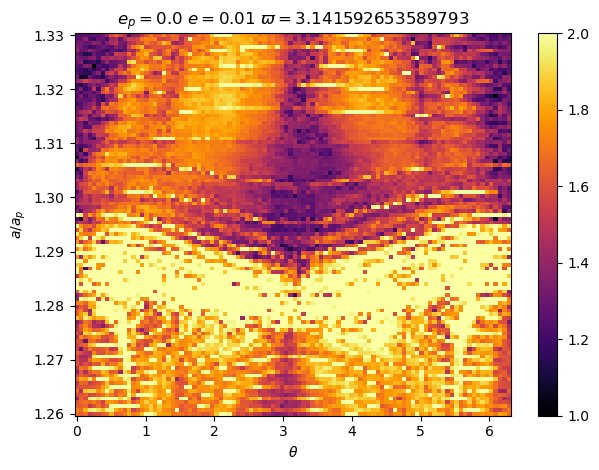

In [109]:
fig, ax = plt.subplots()
cs = ax.pcolormesh(TH2V,AV,RR,vmin=1,vmax=2,cmap="inferno")
ax.set_title(r"$e_p=$"+f"{params[e_p]}"+ r" $e=$"+f"{params['e0']}"+ r" $\varpi=$"+f"{params['pom0']}")
ax.set_ylabel(r"$a/a_p$")
ax.set_xlabel(r"$\theta$")
plt.colorbar(cs)
fig.tight_layout()